In [1]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler, MaxAbsScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans

In [2]:
from varMergeMethod import getBaseData, varMergeByPct, varMergeByChiSquare, varMergeByIVSplit, categoryToWOE

In [3]:
# 1.数据处理
# 2.目标变量分布探索
# 3.拆分训练集和测试集
# 4.输入变量探索
# 5.空值处理
# 6.数值型变量处理
# 7.种类型变量处理

### 1. 数据读取

In [4]:
# 本例数据来源：https://www.kaggle.com/c/walmart-recruiting-trip-type-classification/data
dat = pd.read_csv('./data/train.csv', dtype={'TripType':'category'
                                             ,'VisitNumber':object})

In [5]:
dat.shape

(647054, 7)

### 2. 数据集是否有目标变量y，如果有的话，查看目标变量的y分布，判断分布是否均衡

In [6]:
y_col_name = 'TripType'

y_dist = dat[y_col_name].value_counts() # y_dist为Series
y_dist_df = y_dist.reset_index()  # 将Series转换为DataFrame
y_dist_df.columns = [y_col_name, 'Cnt']
y_dist_df['CumCnt'] = y_dist_df.Cnt.cumsum()
y_dist_df['CntPct'] = np.around(y_dist_df.Cnt/y_dist_df.Cnt.sum(),4)
y_dist_df['CmtCntPct'] = np.around(y_dist_df.CumCnt/y_dist_df.Cnt.sum(), 4)

In [7]:
print(y_dist_df.shape)
y_dist_df.head()

(38, 5)


,TripType,Cnt,CumCnt,CntPct,CmtCntPct
0,40,174164,174164,0.2692,0.2692
1,39,95504,269668,0.1476,0.4168
2,37,38954,308622,0.0602,0.4770
3,38,29565,338187,0.0457,0.5227
4,25,27609,365796,0.0427,0.5653


In [8]:
 # 类的最大数量级和类的最小数量级
print(int(np.log10(174164)))
print(int(np.log10(35)))

5
1


##### y 分布不均衡，最多样本数的类和最少样本数的类之间有四个数量级之差，不平衡处理参考unBalancedSampleProcess.ipynb

In [9]:
# 后面为简化说明，这里把一个多分类的问题转化为一个二分类的问题
dat2 = dat.copy()
dat2.loc[dat2.TripType!='40', 'Label'] = 0
dat2.loc[dat2.TripType=='40', 'Label'] = 1
dat2.drop(columns='TripType', inplace=True)
dat2.Label.value_counts()

0.0    472890
1.0    174164
Name: Label, dtype: int64

In [10]:
 # 类的最大数量级和类的最小数量级
print(int(np.log10(472890)))
print(int(np.log10(174164)))

5
5


### 3. 为了保证不泄露数据，一开始就把数据拆分为训练集和测试集，所有的数据探索均基于训练集进行

In [11]:
dat2.head()

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,Label
0,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,0.0
1,7,Friday,6.053882e+10,1,SHOES,8931.0,0.0
2,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0,0.0
3,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,0.0
4,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,0.0


In [12]:
from sklearn.model_selection import train_test_split

In [13]:
train_data, test_data = train_test_split(dat2, test_size=0.2, random_state=42)
print(train_data.shape)
print(test_data.shape)

(517643, 7)
(129411, 7)


In [14]:
print("集合整体中目标变量为1的比例:", dat2.Label.value_counts()[1]/dat2.Label.value_counts().sum())
print("训练集中目标变量为1的比例:",train_data.Label.value_counts()[1]/train_data.Label.value_counts().sum())

集合整体中目标变量为1的比例: 0.26916455195393274
训练集中目标变量为1的比例: 0.269289838749872


### 4. 对训练集中的数据做探索

In [15]:
train_data.head()

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,Label
296097,89209,Friday,6.053886e+10,1,FINANCIAL SERVICES,0.0,0.0
65508,18368,Sunday,3.400054e+09,1,"CANDY, TOBACCO, COOKIES",707.0,1.0
84182,24048,Monday,2.733103e+09,1,COMM BREAD,3729.0,0.0
293765,88409,Friday,2.120060e+09,1,HOUSEHOLD CHEMICALS/SUPP,9520.0,0.0
278283,83306,Thursday,4.061000e+03,1,PRODUCE,7501.0,0.0


In [16]:
train_data.dtypes

VisitNumber               object
Weekday                   object
Upc                      float64
ScanCount                  int64
DepartmentDescription     object
FinelineNumber           float64
Label                    float64
dtype: object

In [17]:
y_col = 'Label'
X_cols = [i for i in train_data.columns if i!='Label']

In [18]:
num_cols = train_data[X_cols].select_dtypes(include=['int', 'float']).columns
cat_cols = train_data[X_cols].select_dtypes(include=['object']).columns

In [19]:
def numericalColDesc(dat, cols):
    num_desc = dat[cols].describe(percentiles=[0.05, 0.25, 0.50, 0.75, 0.95]).T
    num_desc['uniquecnt'] = dat[cols].apply(lambda x: len(x.unique()))
    num_desc['nacnt'] = dat[cols].apply(lambda x: x.isna().sum())
    num_desc['napct'] = num_desc['nacnt']/(num_desc['nacnt'] + num_desc['count'])
    num_desc['zerocnt'] = dat[cols].apply(lambda x: np.sum([x==0]))
    num_desc['zeropct'] = num_desc['zerocnt']/(num_desc['nacnt'] + num_desc['count'])
    num_desc['dtype'] = dat[cols].dtypes
    return num_desc

def categoricalColDesc(dat, cols):
    cat_desc = pd.DataFrame(index=cat_cols)
    cat_desc['uniquecnt'] = dat[cols].apply(lambda x: len(x.unique()))
    cat_desc['nacnt'] = dat[cols].apply(lambda x: x.isna().sum())
    cat_desc['count'] = dat[cols].count().values
    cat_desc['napct'] = cat_desc['nacnt']/(cat_desc['nacnt'] + cat_desc['count'])
    cat_desc['valuesdemo'] = dat[cols].apply(lambda x: '|'.join(x.unique().astype(str)[0:5]))
    return cat_desc

In [20]:
numericalColDesc(train_data, num_cols)

,count,mean,std,min,5%,25%,50%,75%,95%,max,uniquecnt,nacnt,napct,zerocnt,zeropct,dtype
Upc,514370.0,3.073337e+10,9.174993e+10,834.0,980020039.0,3.400004e+09,7.050105e+09,3.006700e+10,8.599470e+10,9.789707e+11,89522,3273,0.006323,0,0.000000,float64
ScanCount,517643.0,1.108264e+00,6.975978e-01,-12.0,1.0,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,5.100000e+01,38,0,0.000000,0,0.000000,int64
FinelineNumber,514370.0,3.728635e+03,2.781743e+03,0.0,115.0,1.404000e+03,3.352000e+03,5.501000e+03,9.108000e+03,9.998000e+03,5153,3273,0.006323,3008,0.005811,float64


In [21]:
categoricalColDesc(train_data, cat_cols)

,uniquecnt,nacnt,count,napct,valuesdemo
VisitNumber,90966,0,517643,0.000000,89209|18368|24048|88409|83306
Weekday,7,0,517643,0.000000,Friday|Sunday|Monday|Thursday|Saturday
DepartmentDescription,69,1093,516550,0.002111,"FINANCIAL SERVICES|CANDY, TOBACCO, COOKIES|COM..."


### 5. 对空值进行处理

In [22]:
# 查看有空值的数据
train_data_hasna = train_data[train_data.isna().any(axis=1)]
print(train_data_hasna.shape)
train_data_hasna.Label.value_counts() 
print("有空值的数据中目标变量为1的比例:",train_data_hasna.Label.value_counts()[1]/train_data_hasna.Label.value_counts().sum())

(3273, 7)
有空值的数据中目标变量为1的比例: 0.04857928505957837


In [23]:
# 鉴于空值比例比较低，这里做直接删除处理
train_data_dropna = train_data.dropna(axis=0, how='any')
print(train_data_dropna.shape)
# 也可以做填充处理， 其他填充方式参考emptyValueProcess文件处理
train_data_fillna = train_data.fillna(method='ffill') 
print(train_data_fillna.shape)

(514370, 7)
(517643, 7)


In [24]:
num_desc = numericalColDesc(train_data_dropna, num_cols)
num_desc

,count,mean,std,min,5%,25%,50%,75%,95%,max,uniquecnt,nacnt,napct,zerocnt,zeropct,dtype
Upc,514370.0,3.073337e+10,9.174993e+10,834.0,980020039.0,3.400004e+09,7.050105e+09,3.006700e+10,8.599470e+10,9.789707e+11,89521,0,0.0,0,0.000000,float64
ScanCount,514370.0,1.109538e+00,6.981068e-01,-12.0,1.0,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,5.100000e+01,38,0,0.0,0,0.000000,int64
FinelineNumber,514370.0,3.728635e+03,2.781743e+03,0.0,115.0,1.404000e+03,3.352000e+03,5.501000e+03,9.108000e+03,9.998000e+03,5152,0,0.0,3008,0.005848,float64


In [25]:
cat_desc = categoricalColDesc(train_data_dropna, cat_cols)
cat_desc

,uniquecnt,nacnt,count,napct,valuesdemo
VisitNumber,89711,0,514370,0.0,89209|18368|24048|88409|83306
Weekday,7,0,514370,0.0,Friday|Sunday|Monday|Thursday|Saturday
DepartmentDescription,68,0,514370,0.0,"FINANCIAL SERVICES|CANDY, TOBACCO, COOKIES|COM..."


### 6. 针对数值列进行处理

#### 6.1 标准差为0的列要删除

In [26]:
zero_std_cols = list(num_desc[num_desc['std']==0].index)
num_cols = [i for i in num_cols if i not in zero_std_cols]

#### 6.2 高度线性相关的列保留一列

In [27]:
def drop_highcorr_cols(dat, cols, y_col, threshold=0.9):
    # 获取列与列之间的相关系数
    corr = dat[cols].corr()
    corr_cols = corr.columns
    np_corr = np.array(corr)

    corr_dict = dict()
    for i in range(corr.shape[0]):
        for j in range(i):
            k = corr_cols[i] + '|' + corr_cols[j]
            corr_dict[k] = abs(np_corr[i, j])
    # return corr_dict
            
    # 将相关系数超过某个阈值的列保留一个，保留的列为和目标变量列相关性更高的列
    corr_cols_drop = []
    for k, v in corr_dict.items():
        if v >= threshold:
            two_cols = k.split('|')
            col1 = two_cols[0]
            col2 = two_cols[1]
            if col1 in corr_cols_drop or col2 in corr_cols_drop:
                continue
            abs_r1 = abs(stats.pearsonr(dat[col1], dat[y_col])[0])
            abs_r2 = abs(stats.pearsonr(dat[col2], dat[y_col])[0])
            if abs_r1 > abs_r2:
                corr_cols_drop.append(col2)
            else:
                corr_cols_drop.append(col1)
    return corr_cols_drop

In [28]:
corr_cols_drop = drop_highcorr_cols(train_data_dropna, num_cols, 'Label')
num_cols = [i for i in num_cols if i not in corr_cols_drop]

In [29]:
num_desc = numericalColDesc(train_data_dropna, num_cols)
num_desc

,count,mean,std,min,5%,25%,50%,75%,95%,max,uniquecnt,nacnt,napct,zerocnt,zeropct,dtype
Upc,514370.0,3.073337e+10,9.174993e+10,834.0,980020039.0,3.400004e+09,7.050105e+09,3.006700e+10,8.599470e+10,9.789707e+11,89521,0,0.0,0,0.000000,float64
ScanCount,514370.0,1.109538e+00,6.981068e-01,-12.0,1.0,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,5.100000e+01,38,0,0.0,0,0.000000,int64
FinelineNumber,514370.0,3.728635e+03,2.781743e+03,0.0,115.0,1.404000e+03,3.352000e+03,5.501000e+03,9.108000e+03,9.998000e+03,5152,0,0.0,3008,0.005848,float64


In [30]:
numerical_processed = pd.DataFrame(index=train_data_dropna.index)

### 6.3 处理具体的数值型变量
对数值型变量不进行离散化<br>
a) 不做任何处理<br>
b) 函数变换，例如数值太小的可以平方处理，数值太大的可以log处理<br>
b) 标准化(e.g., StandardScaler),归一化(e.g., MinMaxScaler, MaxAbsScaler)<br>

对数值型变量进行离散化<br>
a) 变量类型为整数型，且可取值变量<=10，可以直接做OneHot处理<br>
b) 变量类型为整数型，且可取值变量不多<=100，可以直接做聚合处理（卡方聚合，正样本率合并，IV分割），再做OneHot处理<br>
c) 变量可取值较多，或者变量是浮点型，则先分箱（例如等宽分箱，等深分箱），如果分箱数量多可以再做聚合处理，最后做OneHot处理<br>

#### 数值变量不进行离散化

In [31]:
# log处理
numerical_processed['Upc_log'] = np.log(train_data_dropna.Upc)
# 去中心化: 减去均值
numerical_processed['Upc_center'] = train_data_dropna.Upc - np.mean(train_data_dropna['Upc'])
# 标准化处理: 减去均值，除以标准差，可以用StandardScaler
standard_scaler = StandardScaler()
numerical_processed['Upc_standard'] = standard_scaler.fit_transform(train_data_dropna[['Upc']])
# numerical_processed['Upc_center']/np.std(train_data_dropna.Upc)
# 归一化处理: 把数据变为0-1范围内，可以用MinMaxScaler
minmax_scaler = MinMaxScaler()
numerical_processed['Upc_minmax'] = minmax_scaler.fit_transform(train_data_dropna[['Upc']])
# 归一化处理：把数据变为-1~1范围内，可以用MaxAbsScaler
maxabs_scaler = MaxAbsScaler()
numerical_processed['Upc_absmax'] = maxabs_scaler.fit_transform(train_data_dropna[['Upc']])
# 针对有异常值的情况，用RobustScaler（减去中位数，再除以四分位的距离）
robust_scaler = RobustScaler()
numerical_processed['Upc_robust'] = robust_scaler.fit_transform(train_data_dropna[['Upc']])
# median = np.median(train_data_dropna.Upc)
# q25, q75 = np.quantile(train_data_dropna.Upc, [0.25, 0.75], axis=0)
# interval = q75 - q25
# (train_data_dropna.Upc - median)/interval

In [32]:
numerical_processed.head()

,Upc_log,Upc_center,Upc_standard,Upc_minmax,Upc_absmax,Upc_robust
296097,24.826551,2.980549e+10,0.324856,6.183930e-02,6.183930e-02,2.005804
65508,21.947057,-2.733331e+10,-0.297911,3.473090e-03,3.473091e-03,-0.136875
84182,21.728703,-2.800027e+10,-0.305181,2.791812e-03,2.791813e-03,-0.161886
293765,21.474710,-2.861331e+10,-0.311862,2.165600e-03,2.165601e-03,-0.184874
278283,8.309185,-3.073336e+10,-0.334969,3.296319e-09,4.148235e-09,-0.264376


#### 数值变量进行离散化

In [33]:
# 直接做聚合处理，再进行OneHot
sc_merge = varMergeByChiSquare(train_data_dropna, 'ScanCount', 'Label', bins=7) # 采用卡方合并
# sc_merge = varMergeByPct(train_data_dropna, 'ScanCount', 'Label', bins=7) # 采用正样本率合并
# sc_merge = varMergeByIVSplit(dat4, 'ScanCount', 'Label', bins=7) # 采用IV分割
print(sc_merge, end='\n\n')
sc_interval = []
for i in range(sc_merge.shape[0]):
    tmp = sc_merge.interval[i]
    details = tmp.replace('<=', '').replace('(', '').replace(']', '').replace('>', '').split(',')
    for d in details:
        if d not in sc_interval:
            sc_interval.append(d)
sc_interval = [int(float(i)) for i in sc_interval]
print("Before:", sc_interval)

# 要加上最下限和最上限
sc_range_bottom = train_data_dropna['ScanCount'].min() - round(train_data_dropna['ScanCount'].std())
sc_range_top = train_data_dropna['ScanCount'].max() + round(train_data_dropna['ScanCount'].std())
sc_interval = [sc_range_bottom] + sc_interval + [sc_range_top]
print("After:", sc_interval)

sc_merge_df = pd.cut(train_data_dropna['ScanCount'], sc_interval)
print(sc_merge_df.value_counts())
#  OneHot处理
sc_merge_cat = pd.get_dummies(sc_merge_df, drop_first=True)
sc_merge_cat.columns = ['sc_' + str(i) for i in sc_merge_cat.columns]
numerical_processed = pd.concat([numerical_processed, sc_merge_cat], axis=1)


    variable     interval    flag_0    flag_1
0  ScanCount       <=-1.0   11372.0     897.0
1  ScanCount   (-1.0,1.0]  326103.0  120060.0
2  ScanCount    (1.0,4.0]   35973.0   17473.0
3  ScanCount    (4.0,5.0]     771.0     328.0
4  ScanCount   (5.0,19.0]     898.0     476.0
5  ScanCount  (19.0,46.0]      16.0       2.0
6  ScanCount        >46.0       0.0       1.0

Before: [-1, 1, 4, 5, 19, 46]
After: [-13, -1, 1, 4, 5, 19, 46, 52]
(-1, 1]      446163
(1, 4]        53446
(-13, -1]     12269
(5, 19]        1374
(4, 5]         1099
(19, 46]         18
(46, 52]          1
Name: ScanCount, dtype: int64


In [34]:
numerical_processed.head()

,Upc_log,Upc_center,Upc_standard,Upc_minmax,Upc_absmax,Upc_robust,"sc_(-1, 1]","sc_(1, 4]","sc_(4, 5]","sc_(5, 19]","sc_(19, 46]","sc_(46, 52]"
296097,24.826551,2.980549e+10,0.324856,6.183930e-02,6.183930e-02,2.005804,1,0,0,0,0,0
65508,21.947057,-2.733331e+10,-0.297911,3.473090e-03,3.473091e-03,-0.136875,1,0,0,0,0,0
84182,21.728703,-2.800027e+10,-0.305181,2.791812e-03,2.791813e-03,-0.161886,1,0,0,0,0,0
293765,21.474710,-2.861331e+10,-0.311862,2.165600e-03,2.165601e-03,-0.184874,1,0,0,0,0,0
278283,8.309185,-3.073336e+10,-0.334969,3.296319e-09,4.148235e-09,-0.264376,1,0,0,0,0,0


In [35]:
# 等宽分箱：把变量的取值范围分为k个等宽的区间
cut_by_width, bin_bywidth = pd.cut(train_data_dropna['ScanCount'], bins=5, retbins=True)
print(bin_bywidth)
cut_by_width.value_counts()

[-12.063   0.6    13.2    25.8    38.4    51.   ]


(0.6, 13.2]       502046
(-12.063, 0.6]     12269
(13.2, 25.8]          51
(38.4, 51.0]           2
(25.8, 38.4]           2
Name: ScanCount, dtype: int64

In [36]:
# 等深分箱：把变量的取值个数等分为k个部分
cut_by_depth, bin_bydepth = pd.qcut(train_data_dropna['ScanCount'], q=5, retbins=True, duplicates='drop')
# 这个例子里ScanCount中1取值个数占比约87%，虽然设置了分箱数量为5，
# 但无法实现等深分箱，在使用等深分箱时需要设置duplicates参数，去除重复的1
# 实际分完只有2个箱子
print(bin_bydepth)
cut_by_depth.value_counts()

[-12.   1.  51.]


(-12.001, 1.0]    458432
(1.0, 51.0]        55938
Name: ScanCount, dtype: int64

In [37]:
# 先分箱，然后做聚合处理，再进行OneHot
fl_df = train_data[['FinelineNumber', 'Label']].copy()
fl_cutbydepth, fl_interval = pd.qcut(fl_df['FinelineNumber'], q=20, retbins=True, duplicates='drop')
print("分箱节点:", fl_interval, end='\n\n')
fl_df['bin_FinelineNumber'] = fl_cutbydepth
# 这里用的自上而下的IV分割进行合并的，也可以用卡方检验或者正样本率合并
fl_merge = varMergeByIVSplit(fl_df, 'bin_FinelineNumber', 'Label', bins=5, varInterval=True)

fl_interval = []
for i in range(fl_merge.shape[0]):
    tmp = fl_merge.interval[i]
    details = tmp.replace('<=', '').replace('(', '').replace(']', '').replace('>', '').split(',')
    for d in details:
        if d not in fl_interval:
            fl_interval.append(d)
fl_interval = [int(float(i)) for i in fl_interval]
print("合并后节点（Before）:", fl_interval)

# 要加上最下限和最上限
fl_range_bottom = train_data_dropna['FinelineNumber'].min() - round(train_data_dropna['FinelineNumber'].std())
fl_range_top = train_data_dropna['FinelineNumber'].max() + round(train_data_dropna['FinelineNumber'].std())
fl_interval = [fl_range_bottom] + fl_interval + [fl_range_top]
print("合并后节点(After):", fl_interval)

fl_merge_df = pd.cut(train_data_dropna['FinelineNumber'], fl_interval)
print(fl_merge_df.value_counts())
#  OneHot处理
fl_merge_cat = pd.get_dummies(fl_merge_df, drop_first=True)
fl_merge_cat.columns = ['fl_' + str(i) for i in fl_merge_cat.columns]
numerical_processed = pd.concat([numerical_processed, fl_merge_cat], axis=1)


分箱节点: [   0.  115.  276.  700. 1025. 1404. 1701. 2078. 2603. 3030. 3352. 3665.
 4005. 4450. 4900. 5501. 6300. 7508. 8101. 9108. 9998.]

合并后节点（Before）: [1025, 2603, 4900, 6300]
合并后节点(After): [-2782.0, 1025, 2603, 4900, 6300, 12780.0]
(2603.0, 4900.0]     154252
(-2782.0, 1025.0]    102916
(1025.0, 2603.0]     102894
(6300.0, 12780.0]    102476
(4900.0, 6300.0]      51832
Name: FinelineNumber, dtype: int64


In [38]:
numerical_processed.head()

,Upc_log,Upc_center,Upc_standard,Upc_minmax,Upc_absmax,Upc_robust,"sc_(-1, 1]","sc_(1, 4]","sc_(4, 5]","sc_(5, 19]","sc_(19, 46]","sc_(46, 52]","fl_(1025.0, 2603.0]","fl_(2603.0, 4900.0]","fl_(4900.0, 6300.0]","fl_(6300.0, 12780.0]"
296097,24.826551,2.980549e+10,0.324856,6.183930e-02,6.183930e-02,2.005804,1,0,0,0,0,0,0,0,0,0
65508,21.947057,-2.733331e+10,-0.297911,3.473090e-03,3.473091e-03,-0.136875,1,0,0,0,0,0,0,0,0,0
84182,21.728703,-2.800027e+10,-0.305181,2.791812e-03,2.791813e-03,-0.161886,1,0,0,0,0,0,0,1,0,0
293765,21.474710,-2.861331e+10,-0.311862,2.165600e-03,2.165601e-03,-0.184874,1,0,0,0,0,0,0,0,0,1
278283,8.309185,-3.073336e+10,-0.334969,3.296319e-09,4.148235e-09,-0.264376,1,0,0,0,0,0,0,0,0,1


### 7. 针对种类数据列进行处理

In [39]:
categorical_processed = pd.DataFrame(index=train_data_dropna.index)

#### 7.1 种类可取值只有一个的变量要删除

#### 7.2 处理具体种类变量
a) 种类变量之间有顺序关系<br>
    可以使用map将变量转换为数值型，后面参考数值型变量进行处理<br>

b) 种类变量之间无顺序关系<br>
    当种类数目较少时，可以用OneHot(具体可以使用get_dummies或者OnetHotEncoder)<br>
    当种类数目较多时，可以先聚合，再用OneHot或者用WOE编码（用WOE值代表类别）

#### 种类变量之间有顺序关系: map指定顺序转化

In [40]:
weekday_mapper = {
    "Monday":1,
    "Tuesday":2,
    "Wednesday":3,
    "Thursday":4,
    "Friday":5,
    "Saturday":6,
    "Sunday":7
}
categorical_processed['Weekday_map'] = train_data_dropna.Weekday.map(weekday_mapper) #用map可以随心指定顺序

In [41]:
# 可以用LabelEncoder或者OrdinalEncoder,但是转换后的数字是按照字母排序的
# 不一定符合实际情况，例如下面按字母排序：'Friday'<'Monday'<'Saturday'<'Sunday'<'Thursday'<'Tuesday'<'Wednesday'
# 显然星期不是上面这样的顺序
# m = list(weekday_mapper.keys())
# m.sort()
# m
wm_le = LabelEncoder().fit_transform(train_data_dropna['Weekday'])# 输入参数可以是一维数组
wm_oe = OrdinalEncoder().fit_transform(train_data_dropna[['Weekday']]) # 输入参数必须是二维数组的形式
tmp = pd.concat([train_data_dropna.Weekday, categorical_processed.Weekday_map], axis=1)
tmp['Weekday_le'] = wm_le
tmp['Weekday_oe'] = wm_oe


In [42]:
tmp.head()

,Weekday,Weekday_map,Weekday_le,Weekday_oe
296097,Friday,5,0,0.0
65508,Sunday,7,3,3.0
84182,Monday,1,1,1.0
293765,Friday,5,0,0.0
278283,Thursday,4,4,4.0


In [43]:
# 如果取值少，直接OneHot；
# 如果取值多，需要转换为数值后先聚合再OneHot，
# 但是LabelOrder或者OridincalEncoder顺序是字母顺序，并不一定是真实的大小顺序，
# 所以个人感觉LabelEncoder和OrdinalEncoder没有什么用；

#### 种类变量之间无顺序关系

In [44]:
# 假设星期之间没有顺序关系
pd.get_dummies(train_data_dropna['Weekday']).head()

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
296097,1,0,0,0,0,0,0
65508,0,0,0,1,0,0,0
84182,0,1,0,0,0,0,0
293765,1,0,0,0,0,0,0
278283,0,0,0,0,1,0,0


In [45]:
# 去掉第一个变量，防止共线性
pd.get_dummies(train_data_dropna['Weekday'], drop_first=True).head()

,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
296097,0,0,0,0,0,0
65508,0,0,1,0,0,0
84182,1,0,0,0,0,0
293765,0,0,0,0,0,0
278283,0,0,0,1,0,0


In [46]:
# 使用OneHotEncoder
wkd_ohe = OneHotEncoder(handle_unknown='ignore').fit_transform(train_data_dropna[["Weekday"]]).toarray() # 输入参数必须是二维数组的形式
pd.DataFrame(wkd_ohe).head()

# from sklearn.compose import ColumnTransformer
# categorical_features = ['Weekday']
# cat = ColumnTransformer(transformers=[
#     ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])
# tmp2 = cat.fit_transform(train_data_dropna).toarray()
# pd.DataFrame(tmp2).head()

,0,1,2,3,4,5,6
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [47]:
categorical_processed.head()

,Weekday_map
296097,5
65508,7
84182,1
293765,5
278283,4


In [48]:
# 先聚合再用OneHot

In [49]:
group_by_depart = getBaseData(train_data_dropna, 'DepartmentDescription', 'Label', varOrder=False)
group_by_depart_df = pd.DataFrame(group_by_depart, columns=['DepartmentDescription', 'positive_class', 'negative_class'])
group_by_depart_df['positive_pct'] = group_by_depart_df['positive_class']/(group_by_depart_df['positive_class']+group_by_depart_df['negative_class'])

In [50]:
group_by_depart_df.head()

,DepartmentDescription,positive_class,negative_class,positive_pct
0,PHARMACY RX,0,119,0
1,OTHER DEPARTMENTS,0,21,0
2,OPTICAL - LENSES,0,73,0
3,LARGE HOUSEHOLD GOODS,0,54,0
4,HEALTH AND BEAUTY AIDS,0,2,0


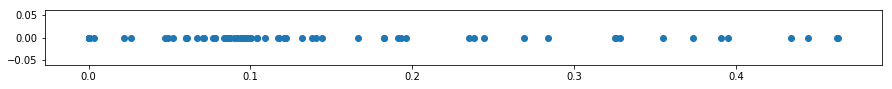

In [51]:
# 绘制正样本占比的散点图，肉眼观察分为几类合适
fig, ax = plt.subplots(figsize=(15, 1)) 
x = group_by_depart_df.positive_pct.values
y = [0]*group_by_depart_df.shape[0]
ax.scatter(x, y, marker='o')

In [52]:
# 聚合方法：卡方聚合，正样本率合并，IV分割
# depart_merge = varMergeByChiSquare(train_data_dropna, 'DepartmentDescription', 'Label', bins=10, varOrder=False)
# depart_merge = varMergeByPct(train_data_dropna, 'DepartmentDescription', 'Label', bins=10, varOrder=False)
depart_merge = varMergeByIVSplit(train_data_dropna, 'DepartmentDescription', 'Label', bins=10, varOrder=False)
depart_groups = dict()
for i in range(depart_merge.shape[0]):
    v = depart_merge.interval.values[i].split('|')
    depart_groups[i] = v

# 也可以使用KMeans聚类进行合并
# estimator = KMeans(n_clusters=10)
# estimator.fit(group_by_depart_df[['positive_pct']])
# group_by_depart_df['GroupByKMeans'] = estimator.labels_
# depart_groups = group_by_depart_df.groupby(['GroupByKMeans']).apply(lambda x: list(x.DepartmentDescription.values)).to_dict()

In [53]:
depart_groups

{0: ['PHARMACY RX',
  'OTHER DEPARTMENTS',
  'OPTICAL - LENSES',
  'LARGE HOUSEHOLD GOODS',
  'HEALTH AND BEAUTY AIDS',
  'CONCEPT STORES',
  '1-HR PHOTO'],
 1: ['CAMERAS AND SUPPLIES',
  'WIRELESS',
  'FURNITURE',
  'FINANCIAL SERVICES',
  'ELECTRONICS',
  'MENS WEAR',
  'JEWELRY AND SUNGLASSES',
  'OPTICAL - FRAMES',
  'SWIMWEAR/OUTERWEAR',
  'BOYS WEAR',
  'PLAYERS AND ELECTRONICS'],
 2: ['AUTOMOTIVE',
  'PAINT AND ACCESSORIES',
  'SPORTING GOODS',
  'BEDDING',
  'MENSWEAR',
  'BRAS & SHAPEWEAR',
  'LADIESWEAR',
  'SHOES',
  'SHEER HOSIERY',
  'ACCESSORIES'],
 3: ['FABRICS AND CRAFTS',
  'MEDIA AND GAMING',
  'CELEBRATION',
  'PLUS AND MATERNITY',
  'TOYS',
  'HORTICULTURE AND ACCESS',
  'OFFICE SUPPLIES',
  'HARDWARE',
  'GIRLS WEAR, 4-6X  AND 7-14',
  'INFANT APPAREL',
  'BATH AND SHOWER',
  'SLEEPWEAR/FOUNDATIONS'],
 4: ['LADIES SOCKS',
  'HOME MANAGEMENT',
  'HOME DECOR',
  'LAWN AND GARDEN',
  'BOOKS AND MAGAZINES',
  'IMPULSE MERCHANDISE'],
 5: ['SEASONAL',
  'BEAUTY',
  'COOK

In [54]:
for k, v in depart_groups.items():
    train_data_dropna.loc[train_data_dropna.DepartmentDescription.isin(v), 'merge_DepartmentDescription'] = k

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [55]:
merge_depart_ohe = pd.get_dummies(train_data_dropna['merge_DepartmentDescription'])
merge_depart_ohe.index = train_data_dropna.index
merge_depart_ohe.columns=['DepartDesc_'+ str(i) for i in merge_depart_ohe.columns]

categorical_processed = pd.merge(categorical_processed, merge_depart_ohe, left_index=True, right_index=True)
train_data_dropna.drop(columns=['merge_DepartmentDescription'], inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [56]:
# WOE编码(将种类转换为数值型)
woe = categoryToWOE(train_data_dropna,'DepartmentDescription', 'Label', varOrder=False)
train_data_dropna = pd.merge(train_data_dropna, woe, on='DepartmentDescription', how='inner')
categorical_processed['Department_WOE'] = train_data_dropna['DepartmentDescription_WOE']
train_data_dropna.drop(columns=['DepartmentDescription_WOE'], inplace=True)

In [57]:
train_data_dropna.head()

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,Label
0,89209,Friday,6.053886e+10,1,FINANCIAL SERVICES,0.0,0.0
1,177793,Friday,6.053886e+10,1,FINANCIAL SERVICES,0.0,1.0
2,14327,Sunday,6.053890e+10,1,FINANCIAL SERVICES,276.0,0.0
3,134567,Friday,6.053886e+10,1,FINANCIAL SERVICES,0.0,0.0
4,135459,Friday,6.053880e+10,-1,FINANCIAL SERVICES,799.0,0.0


In [58]:
categorical_processed.head()

,Weekday_map,DepartDesc_0.0,DepartDesc_1.0,DepartDesc_2.0,DepartDesc_3.0,DepartDesc_4.0,DepartDesc_5.0,DepartDesc_6.0,DepartDesc_7.0,DepartDesc_8.0,DepartDesc_9.0,Department_WOE
296097,5,0,1,0,0,0,0,0,0,0,0,-0.790318
65508,7,0,0,0,0,0,0,1,0,0,0,0.276474
84182,1,0,0,0,0,0,0,0,0,1,0,0.276474
293765,5,0,0,0,0,0,0,0,1,0,0,-0.790318
278283,4,0,0,0,0,0,0,0,1,0,0,0.563976
